# Подключаем библиотеки и определяем устройство

In [1]:
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torch.autograd import Variable
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Задаем переменные

In [15]:
batch_size = 128
image_size = 32
num_epochs = 50
conv_dim = 2
latent_layer = 2

# Прописываем архитектуру сети

In [25]:
class Encoder(nn.Module):
    def __init__(self, conv_dim=conv_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, conv_dim, 4,2,1)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim*2, 4,2,1)
        self.conv3 = nn.Conv2d(conv_dim*2, conv_dim*4, 4,2,1)
        self.conv4 = nn.Conv2d(conv_dim*4, 64, 4,2,0)
        self.fc = nn.Linear(64, 128)
        self.mu = nn.Linear(128, latent_layer)
        self.logvar = nn.Linear(128,latent_layer)


    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)
        out = F.leaky_relu(self.conv2(out), 0.05)
        out = F.leaky_relu(self.conv3(out), 0.05)
        out = F.leaky_relu(self.conv4(out), 0.05)
        out = F.adaptive_max_pool2d(out, 1).reshape(batch_size, -1)
        out = self.fc(out)
        mu = self.mu(out)
        logvar = self.logvar(out)
        return mu,logvar


class Decoder(nn.Module):
    def __init__(self, z_dim=latent_layer, conv_dim=conv_dim):
        super(Decoder, self).__init__()
        self.fc0 = nn.Linear(z_dim, 64)
#         self.fc = deconv(conv_dim*2, conv_dim*2, int(image_size/16), 1, 0)
        self.deconv1 = nn.ConvTranspose2d(64,conv_dim*8, 4, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(conv_dim*8, conv_dim*4, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 4, 2, 1)
        self.deconv4 = nn.ConvTranspose2d(conv_dim*2, 1, 4, 2, 1)

    def forward(self, z):
        out = self.fc0(z)
        out = out.view(-1, 64, 1, 1)
#         out = self.fc(out)
        out = F.leaky_relu(self.deconv1(out), 0.05)
        out = F.leaky_relu(self.deconv2(out), 0.05)
        out = F.leaky_relu(self.deconv3(out), 0.05)
        out = F.sigmoid(self.deconv4(out))
        return out

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.z = 0

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample

    def forward(self, x):
        mu,logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z),mu,logvar

# Инициализируем модель

In [26]:
model = Autoencoder().cuda()
min_loss = np.inf

# Загружаем данные и создаем лоадеры

In [27]:
data = torchvision.datasets.MNIST('./data',transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((image_size, image_size))]),download=True)

m=len(data)
k_valid = 0.1

train_data = torch.utils.data.Subset(data,list(range(int(m-m*k_valid))))
val_data = torch.utils.data.Subset(data,list(range(int(m-m*k_valid),len(data)-1)))

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=6, drop_last=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False, num_workers=6, drop_last=True)

# Учим модель

In [28]:
learning_rate = 0.0005
criterion = nn.BCELoss(reduction='mean')
r_loss_factor = 50
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5
                            )
model.train()
# optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, )
for epoch in range(num_epochs):
    sum_loss = 0
    sum_loss_mse = 0
    sum_loss_kld = 0
    for i, data in enumerate(train_loader):
        model.zero_grad()
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
#         output = model(img)
#         VAE
        output,mu,logvar = model(img)
#         MSE = F.binary_cross_entropy(output, img, size_average=False)
        MSE = criterion(output,img)
#         MSE = torch.mean(torch.square(img - output))
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = r_loss_factor * MSE + KLD
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 200  == 0:
            print(f'iter: {i}, Loss:{sum_loss/(i+1)}')
    # ===================log========================
        sum_loss += loss.data
        sum_loss_mse += MSE
        sum_loss_kld += KLD
    total_loss = sum_loss/len(train_loader)
    total_loss_mse = sum_loss_mse/len(train_loader)
    total_loss_kld = sum_loss_kld/len(train_loader)
    if total_loss<min_loss:
        torch.save(model.state_dict(), 'best_VAE.pth')
        min_loss=total_loss
        print('epoch [{}/{}], loss:{:.4f}, mse_loss:{:.4f}, kld_loss:{:.4f}, best_loss:{:.5f}, save_best_weight'
          .format(epoch+1, num_epochs, total_loss, total_loss_mse, total_loss_kld,min_loss))
    else:
        print('epoch [{}/{}], loss:{:.4f}, mse_loss:{:.4f}, kld_loss:{:.4f}, best_loss:{:.5f}'
          .format(epoch+1, num_epochs, total_loss, total_loss_mse, total_loss_kld, min_loss))


iter: 0, Loss:0.0
iter: 200, Loss:27.533409118652344
iter: 400, Loss:20.80719566345215
epoch [1/50], loss:20.4909, mse_loss:0.4054, kld_loss:0.2189, best_loss:20.49088, save_best_weight
iter: 0, Loss:0.0
iter: 200, Loss:13.088037490844727
iter: 400, Loss:13.048157691955566
epoch [2/50], loss:13.0762, mse_loss:0.2534, kld_loss:0.4038, best_loss:13.07616, save_best_weight
iter: 0, Loss:0.0
iter: 200, Loss:12.81430435180664
iter: 400, Loss:12.83691692352295
epoch [3/50], loss:12.8698, mse_loss:0.2484, kld_loss:0.4484, best_loss:12.86979, save_best_weight
iter: 0, Loss:0.0
iter: 200, Loss:12.74777889251709
iter: 400, Loss:12.720755577087402
epoch [4/50], loss:12.7411, mse_loss:0.2443, kld_loss:0.5275, best_loss:12.74105, save_best_weight
iter: 0, Loss:0.0
iter: 200, Loss:12.449758529663086
iter: 400, Loss:12.443955421447754
epoch [5/50], loss:12.4671, mse_loss:0.2327, kld_loss:0.8333, best_loss:12.46713, save_best_weight
iter: 0, Loss:0.0
iter: 200, Loss:12.32576847076416
iter: 400, Loss:1

In [ ]:
# Функция визуализации цифры из скрытого пространства
def plot_reconstructed(autoencoder, r0=(-3, 3), r1=(-3, 3), n=12):
    w = image_size
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(image_size, image_size).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
plot_reconstructed(model)

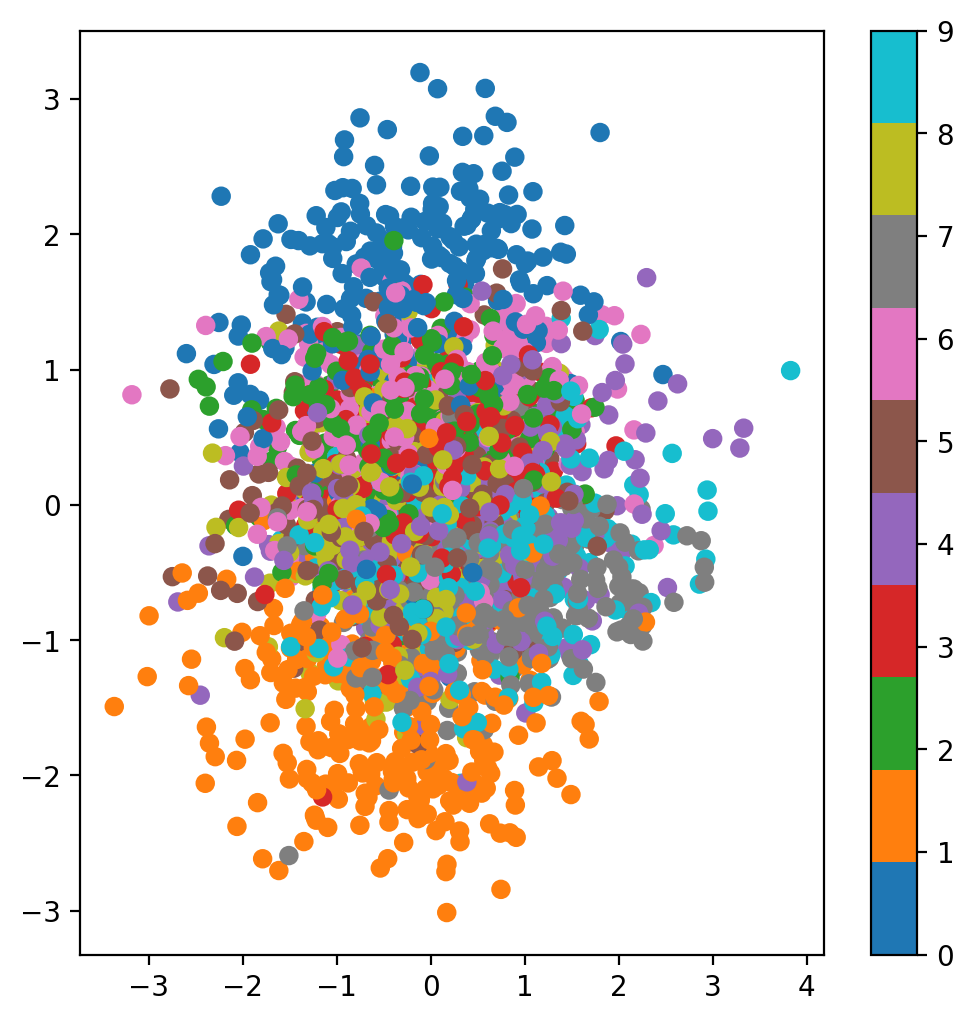

In [24]:
def reparameterize(mu, logvar):
    std = logvar.mul(0.5).exp_()
    # return torch.normal(mu, std)
    esp = torch.randn(*mu.size()).cuda()
    z = mu + std * esp
    return z

# Функция визуализации скрытого пространства
def plot_latent(autoencoder, data, num_batches=20):
    autoencoder.eval()
    fig, axes = plt.subplots(figsize=(6, 6))
    for i, (x, y) in enumerate(data):
        mu, logvar = autoencoder.encoder(x.to(device))
        # mu = mu.to('cpu').detach().numpy()
        # logvar = logvar.to('cpu').detach().numpy()
        z = reparameterize(mu,logvar).to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
plot_latent(model, valid_loader)